In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
sys.path.append('../training_minimalCut_wPt')


%load_ext autoreload
%autoreload 2

from dataLoader import PhotonDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

from matplotlib import pyplot as plt
from scipy import stats

from sklearn.metrics import roc_curve, auc

import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

mpl.rc('font', **font)
mpl.rcParams['savefig.dpi'] = 300

In [2]:
model_path = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/training_minimalCut_wPt/models/state_dict_highCtau_best.pth'
mean_path = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/training_minimalCut_wPt/mean.npy'
std_path = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/training_minimalCut_wPt/std.npy'
dataset_path = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/preprocessing/skim_analyzer_output_reproduce_minimalCut_cutBothPho//csv_out/'
test_indices_path = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/training_minimalCut_wPt/test_indices.npy'
random_seed = 42
### Check CUDA availability
isCUDA = torch.cuda.is_available()

# For reproducibility
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
### load model
from model import net
if isCUDA:
    net = net.cuda()

net.load_state_dict(torch.load(model_path))
net.eval()

### load data and test indices
ds = PhotonDataset(dataset_path, loadIso=True, loadProcess=True)
dataset_size = len(ds)
print("Loading {} events".format(dataset_size))

# Train test split
validation_split = 0.4
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

#test_indices = np.load(test_indices_path) #range(len(ds))#
test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader(ds, batch_size=10000) #, sampler=test_sampler)

### Get mean and std
#mean, std = ds.calculateMeanAndSigma()
#print("*** MEAN ***\n{}".format(mean))
#print("*** STD ***\n {}".format(std))
mean = np.load(mean_path)
std = np.load(std_path)
mean = torch.from_numpy(np.array(mean)).float()
std = torch.from_numpy(np.array(std)).float()

if isCUDA:
    mean = mean.cuda()
    std = std.cuda()

print("Process dict:")
print(ds.processDict)

Merging 24 background files


../training_minimalCut_wPt/dataLoader.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['process'] = self.processDict[process]
../training_minimalCut_wPt/dataLoader.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Lambda'] = 0


Number of background events: 3526182
Merging 52 signal files


../training_minimalCut_wPt/dataLoader.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['process'] = 0
../training_minimalCut_wPt/dataLoader.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Lambda'] = this_lambda


Number of signal events: 1291045
Sum weights background : 40.916
Sum weights signal: 1333646.9242020876
Reweighting background by 32594.494743504183
Loading 4817122 events
Process dict:
{'DiPhoton': 1, 'EWK': 2, 'GJet': 3, 'QCD': 4}


In [4]:
### evaluate model performance on the data
all_pred = torch.tensor([])
all_label = torch.tensor([])
all_weight = torch.tensor([])
all_iso = torch.tensor([])
all_input = torch.tensor([])
all_fea = torch.tensor([])
all_process = torch.tensor([]).int()
all_lambda = torch.tensor([]).int()
all_ctau = torch.tensor([]).float()

# if isCUDA:
#     all_pred = all_pred.cuda()
#     all_label = all_label.cuda()
#     all_weight = all_weight.cuda()
#     all_iso = all_iso.cuda()
#     all_input = all_input.cuda()
    
for data in test_loader:
    all_features = data['feature'].float()
    label = data['label'].float()
    iso = data['iso'].float()
    process = data['process'].int()
    Lambda = data['Lambda'].int()
    ctau = data['ctau'].float()
    
    weight = all_features[:, 0] * all_features[:, 1] \
            * all_features[:, 2] * all_features[:, 3] \
            * all_features[:, 4] 
    feature = all_features[:, 7:]
    
    all_input = torch.cat([all_input, feature], 0)
    all_process = torch.cat([all_process, process], 0)
    all_lambda = torch.cat([all_lambda, Lambda], 0)
    all_ctau = torch.cat([all_ctau, ctau], 0)
    
    if isCUDA:
        feature = feature.cuda()
        label = label.cuda()
        weight = weight.cuda()
        iso = iso.cuda()
        

    norm_feature = (feature - mean)/std
    pred = net(norm_feature)
    
    all_pred = torch.cat([all_pred, pred.cpu().data], 0)
    all_label = torch.cat([all_label, label.cpu().data], 0)
    all_weight = torch.cat([all_weight, weight.cpu().data], 0)
    all_iso = torch.cat([all_iso, iso.cpu().data], 0)
    all_fea = torch.cat([all_fea, feature.cpu().data], 0)
    
    
### Convert to numpy
all_pred = all_pred.view_as(all_label).numpy()
all_label = all_label.numpy()
all_weight = all_weight.numpy()
all_iso = all_iso.numpy()
all_input = all_input.numpy()
all_process = all_process.numpy()
all_fea = all_fea.numpy()
all_lambda = all_lambda.numpy()
all_ctau = all_ctau.numpy()

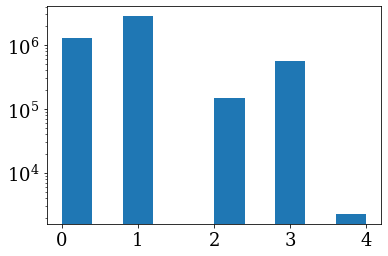

In [5]:
plt.hist(all_process)
plt.yscale('log')

(array([ 75658., 360522., 672169., 422306., 517951., 479241., 360692.,
        238091., 219274., 180205.]),
 array([1.2485620e-04, 1.0011237e-01, 2.0009989e-01, 3.0008739e-01,
        4.0007490e-01, 5.0006241e-01, 6.0004991e-01, 7.0003748e-01,
        8.0002499e-01, 9.0001249e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

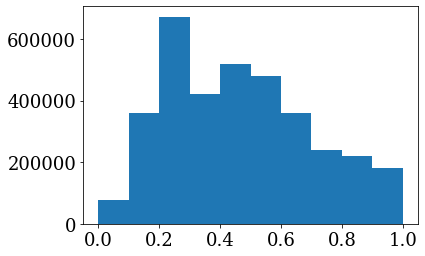

In [6]:
plt.hist(all_pred[all_label==0])

In [7]:
all_real_weight = np.copy(all_weight)
all_real_weight[all_label==1] = 1
sum(all_real_weight[all_label==1])

1291013.0

In [8]:
### Get TPR and FPR with isolation cut
all_signal_weight = all_real_weight[all_label == 1]
all_signal_isoTight_weight = all_real_weight[((all_label==1) * (all_iso[:,2]==1) \
                                        * (all_iso[:,3]==1) * (all_iso[:,4]==1) \
                                        * (all_iso[:,5]==1) * (all_iso[:,6]==1) \
                                        * (all_fea[:, -1]<0.4) ) == 1]

tight_TPR = all_signal_isoTight_weight.sum()/all_signal_weight.sum()
print("Tight TPR = {}".format(tight_TPR))



all_background_weight = all_real_weight[all_label == 0]
all_background_isoTight_weight = all_weight[((all_label==0) * (all_iso[:,2]==1) \
                                        * (all_iso[:,3]==1) * (all_iso[:,4]==1) \
                                        * (all_iso[:,5]==1) * (all_iso[:,6]==1) \
                                        * (all_fea[:, -1]<0.4) ) == 1]

tight_FPR = all_background_isoTight_weight.sum()/all_background_weight.sum()
print("Tight FPR = {}".format(tight_FPR))


Tight TPR = 0.7028589248657227
Tight FPR = 0.3290514051914215


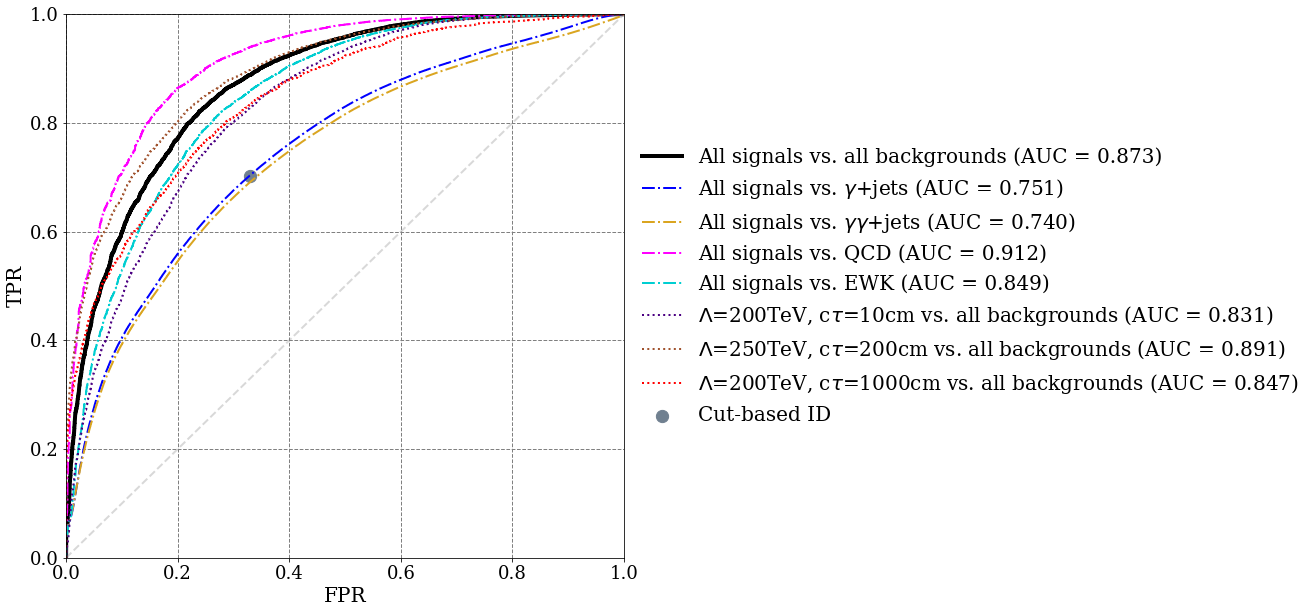

In [9]:
### ROC curve
#### All backgrounds
fpr, tpr, thresholds = roc_curve(all_label[all_iso[:,-1]>70.], all_pred[all_iso[:,-1]>70.], 
                                 sample_weight=all_real_weight[all_iso[:,-1]>70])
sort_idx = np.argsort(fpr)
tpr_sort, fpr_sort, thresholds_sort = tpr[sort_idx], fpr[sort_idx], thresholds[sort_idx]
roc_auc = auc(fpr_sort, tpr_sort)

#### Signal vs. GJets
selected = (all_process == 3) | (all_process == 0)
fpr_gjets, tpr_gjets, thresholds_gjets = roc_curve(all_label[selected], 
                                                   all_pred[selected], 
                                                   sample_weight=all_real_weight[selected])
sort_idx = np.argsort(fpr_gjets)
tpr_sort_gjets, fpr_sort_gjets, thresholds_sort_gjets = tpr_gjets[sort_idx], fpr_gjets[sort_idx], thresholds_gjets[sort_idx]
roc_auc_gjets = auc(fpr_sort_gjets, tpr_sort_gjets)

#### Signal vs. EWK
selected = (all_process == 2) | (all_process == 0)
fpr_ewk, tpr_ewk, thresholds_ewk = roc_curve(all_label[selected], 
                                                   all_pred[selected], 
                                                   sample_weight=all_real_weight[selected])
sort_idx = np.argsort(fpr_ewk)
tpr_sort_ewk, fpr_sort_ewk, thresholds_sort_ewk = tpr_ewk[sort_idx], fpr_ewk[sort_idx], thresholds_ewk[sort_idx]
roc_auc_ewk = auc(fpr_sort_ewk, tpr_sort_ewk)

#### Signal vs. DiPhoton
selected = (all_process == 1) | (all_process == 0)
fpr_dipho, tpr_dipho, thresholds_dipho = roc_curve(all_label[selected], 
                                                   all_pred[selected], 
                                                   sample_weight=all_real_weight[selected])
sort_idx = np.argsort(fpr_dipho)
tpr_sort_dipho, fpr_sort_dipho, thresholds_sort_dipho = tpr_dipho[sort_idx], fpr_dipho[sort_idx], thresholds_dipho[sort_idx]
roc_auc_dipho = auc(fpr_sort_dipho, tpr_sort_dipho)

#### Signal vs. QCD
selected = (all_process == 4) | (all_process == 0)
fpr_qcd, tpr_qcd, thresholds_qcd = roc_curve(all_label[selected], 
                                                   all_pred[selected], 
                                                   sample_weight=all_real_weight[selected])
sort_idx = np.argsort(fpr_qcd)
tpr_sort_qcd, fpr_sort_qcd, thresholds_sort_qcd = tpr_qcd[sort_idx], fpr_qcd[sort_idx], thresholds_qcd[sort_idx]
roc_auc_qcd = auc(fpr_sort_qcd, tpr_sort_qcd)

### ROC curve bkg vs different signal

# 200_10
selected = ((all_lambda == 200) & (all_ctau.astype(int) == 10)) | (all_process != 0)
fpr_200_10, tpr_200_10, thresholds_200_10 = roc_curve(all_label[selected], 
                                                   all_pred[selected], 
                                                   sample_weight=all_real_weight[selected])
sort_idx = np.argsort(fpr_200_10)
tpr_sort_200_10, fpr_sort_200_10, thresholds_sort_200_10 = tpr_200_10[sort_idx], fpr_200_10[sort_idx], thresholds_200_10[sort_idx]
roc_auc_200_10 = auc(fpr_sort_200_10, tpr_sort_200_10)

# 250_200
selected = ((all_lambda == 250) & (all_ctau.astype(int) == 200)) | (all_process != 0)
fpr_250_200, tpr_250_200, thresholds_250_200 = roc_curve(all_label[selected], 
                                                   all_pred[selected], 
                                                   sample_weight=all_real_weight[selected])
sort_idx = np.argsort(fpr_250_200)
tpr_sort_250_200, fpr_sort_250_200, thresholds_sort_250_200 = tpr_250_200[sort_idx], fpr_250_200[sort_idx], thresholds_250_200[sort_idx]
roc_auc_250_200 = auc(fpr_sort_250_200, tpr_sort_250_200)

# 200_1000
selected = ((all_lambda == 200) & (all_ctau.astype(int) == 1000)) | (all_process != 0)
fpr_200_1000, tpr_200_1000, thresholds_200_1000 = roc_curve(all_label[selected],
                                                   all_pred[selected],
                                                   sample_weight=all_real_weight[selected])
sort_idx = np.argsort(fpr_200_1000)
tpr_sort_200_1000, fpr_sort_200_1000, thresholds_sort_200_1000 = tpr_200_1000[sort_idx], fpr_200_1000[sort_idx], thresholds_200_1000[sort_idx]
roc_auc_200_1000 = auc(fpr_sort_200_1000, tpr_sort_200_1000)


fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot()
ax2.plot(fpr, tpr, lw=4, color='black', label='All signals vs. all backgrounds (AUC = %.3f)' % (roc_auc))
ax2.plot(fpr_gjets, tpr_gjets, lw=2, linestyle='-.', color='blue', label='All signals vs. $\gamma$+jets (AUC = %.3f)' % (roc_auc_gjets))
ax2.plot(fpr_dipho, tpr_dipho, lw=2, linestyle='-.', color='goldenrod', label='All signals vs. $\gamma\gamma$+jets (AUC = %.3f)' % (roc_auc_dipho))
ax2.plot(fpr_qcd, tpr_qcd, lw=2, linestyle='-.', color='magenta', label='All signals vs. QCD (AUC = %.3f)' % (roc_auc_qcd))
ax2.plot(fpr_ewk, tpr_ewk, lw=2, linestyle='-.', color='darkturquoise', label='All signals vs. EWK (AUC = %.3f)' % (roc_auc_ewk))

ax2.plot(fpr_200_10, tpr_200_10, lw=2, linestyle='dotted', color='indigo', label=r'$\Lambda$=200TeV, c$\tau$=10cm vs. all backgrounds (AUC = %.3f)'%(roc_auc_200_10))
ax2.plot(fpr_250_200, tpr_250_200, lw=2, linestyle='dotted', color='sienna', label=r'$\Lambda$=250TeV, c$\tau$=200cm vs. all backgrounds (AUC = %.3f)'%(roc_auc_250_200))
ax2.plot(fpr_200_1000, tpr_200_1000, lw=2, linestyle='dotted', color='red', label=r'$\Lambda$=200TeV, c$\tau$=1000cm vs. all backgrounds (AUC = %.3f)'%(roc_auc_200_1000))


ax2.scatter(tight_FPR, tight_TPR, s=150, c='slategrey', label='Cut-based ID')
#ax2.scatter(loose_FPR, loose_TPR, s=80, c='cyan', label='Tight cut-based ID, $\gamma_{pT}$ > 50 GeV')
ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=0.3)
ax2.set_xlim([0, 1.0])
ax2.set_ylim([0, 1.0])
ax2.set_xlabel('FPR', fontsize=20)
ax2.set_ylabel('TPR', fontsize=20)
ax2.legend(loc='center left', fontsize=20, frameon=0, bbox_to_anchor=(1,0.5))
ax2.grid(color='grey', linestyle='--', linewidth=1)
plt.show()

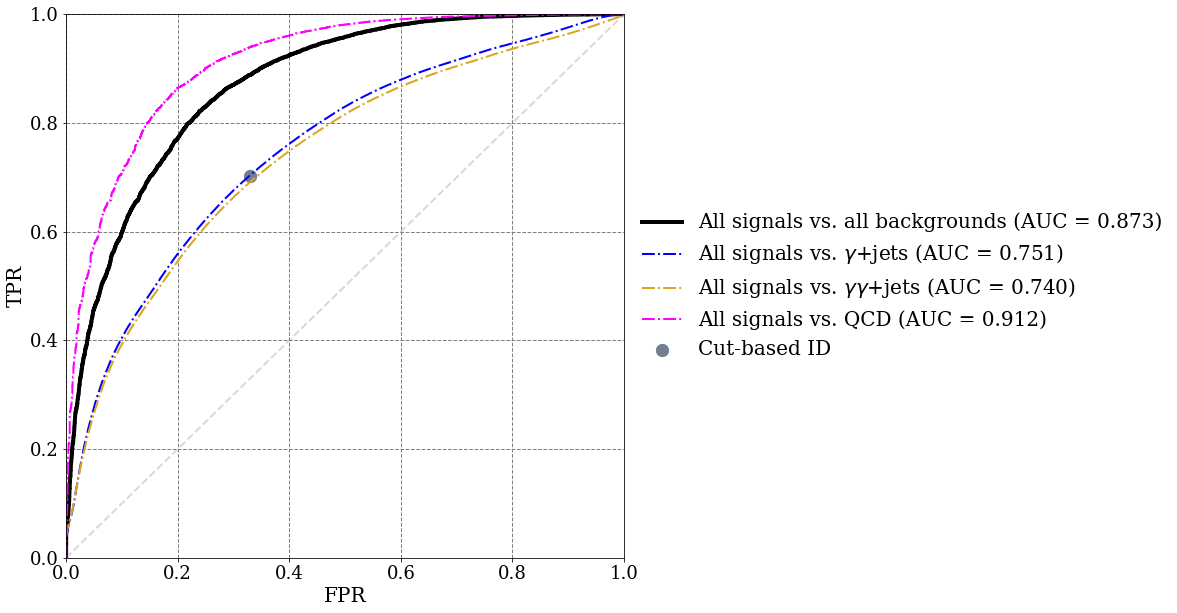

In [21]:
fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot()
ax2.plot(fpr, tpr, lw=4, color='black', label='All signals vs. all backgrounds (AUC = %.3f)' % (roc_auc))
ax2.plot(fpr_gjets, tpr_gjets, lw=2, linestyle='-.', color='blue', label='All signals vs. $\gamma$+jets (AUC = %.3f)' % (roc_auc_gjets))
ax2.plot(fpr_dipho, tpr_dipho, lw=2, linestyle='-.', color='goldenrod', label='All signals vs. $\gamma\gamma$+jets (AUC = %.3f)' % (roc_auc_dipho))
ax2.plot(fpr_qcd, tpr_qcd, lw=2, linestyle='-.', color='magenta', label='All signals vs. QCD (AUC = %.3f)' % (roc_auc_qcd))
#ax2.plot(fpr_ewk, tpr_ewk, lw=2, linestyle='-.', color='darkturquoise', label='All signals vs. EWK (AUC = %.3f)' % (roc_auc_ewk))

# ax2.plot(fpr_200_10, tpr_200_10, lw=2, linestyle='dotted', color='indigo', label=r'$\Lambda$=200TeV, c$\tau$=10cm vs. all backgrounds (AUC = %.3f)'%(roc_auc_200_10))
# ax2.plot(fpr_250_200, tpr_250_200, lw=2, linestyle='dotted', color='sienna', label=r'$\Lambda$=250TeV, c$\tau$=200cm vs. all backgrounds (AUC = %.3f)'%(roc_auc_250_200))
# ax2.plot(fpr_200_1000, tpr_200_1000, lw=2, linestyle='dotted', color='red', label=r'$\Lambda$=200TeV, c$\tau$=1000cm vs. all backgrounds (AUC = %.3f)'%(roc_auc_200_1000))


ax2.scatter(tight_FPR, tight_TPR, s=150, c='slategrey', label='Cut-based ID')
#ax2.scatter(loose_FPR, loose_TPR, s=80, c='cyan', label='Tight cut-based ID, $\gamma_{pT}$ > 50 GeV')
ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=0.3)
ax2.set_xlim([0, 1.0])
ax2.set_ylim([0, 1.0])
ax2.set_xlabel('FPR', fontsize=20)
ax2.set_ylabel('TPR', fontsize=20)
ax2.legend(loc='center left', fontsize=20, frameon=0, bbox_to_anchor=(1,0.5))
ax2.grid(color='grey', linestyle='--', linewidth=1)
plt.show()

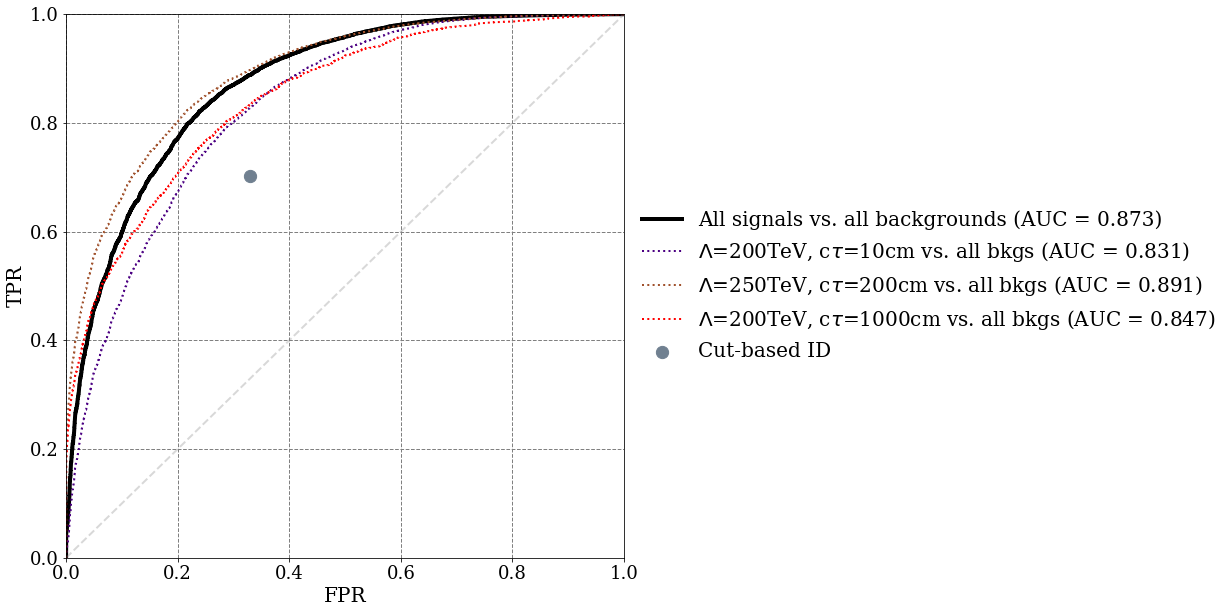

In [23]:
fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot()
ax2.plot(fpr, tpr, lw=4, color='black', label='All signals vs. all backgrounds (AUC = %.3f)' % (roc_auc))
# ax2.plot(fpr_gjets, tpr_gjets, lw=2, linestyle='-.', color='blue', label='All signals vs. $\gamma$+jets (AUC = %.3f)' % (roc_auc_gjets))
# ax2.plot(fpr_dipho, tpr_dipho, lw=2, linestyle='-.', color='goldenrod', label='All signals vs. $\gamma\gamma$+jets (AUC = %.3f)' % (roc_auc_dipho))
# ax2.plot(fpr_qcd, tpr_qcd, lw=2, linestyle='-.', color='magenta', label='All signals vs. QCD (AUC = %.3f)' % (roc_auc_qcd))
#ax2.plot(fpr_ewk, tpr_ewk, lw=2, linestyle='-.', color='darkturquoise', label='All signals vs. EWK (AUC = %.3f)' % (roc_auc_ewk))

ax2.plot(fpr_200_10, tpr_200_10, lw=2, linestyle='dotted', color='indigo', label=r'$\Lambda$=200TeV, c$\tau$=10cm vs. all bkgs (AUC = %.3f)'%(roc_auc_200_10))
ax2.plot(fpr_250_200, tpr_250_200, lw=2, linestyle='dotted', color='sienna', label=r'$\Lambda$=250TeV, c$\tau$=200cm vs. all bkgs (AUC = %.3f)'%(roc_auc_250_200))
ax2.plot(fpr_200_1000, tpr_200_1000, lw=2, linestyle='dotted', color='red', label=r'$\Lambda$=200TeV, c$\tau$=1000cm vs. all bkgs (AUC = %.3f)'%(roc_auc_200_1000))


ax2.scatter(tight_FPR, tight_TPR, s=150, c='slategrey', label='Cut-based ID')
#ax2.scatter(loose_FPR, loose_TPR, s=80, c='cyan', label='Tight cut-based ID, $\gamma_{pT}$ > 50 GeV')
ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=0.3)
ax2.set_xlim([0, 1.0])
ax2.set_ylim([0, 1.0])
ax2.set_xlabel('FPR', fontsize=20)
ax2.set_ylabel('TPR', fontsize=20)
ax2.legend(loc='center left', fontsize=20, frameon=0, bbox_to_anchor=(1,0.5))
ax2.grid(color='grey', linestyle='--', linewidth=1)
plt.show()

In [10]:
thresholds_200_10[-4:]

array([0.00020874, 0.00016076, 0.00013248, 0.00012486], dtype=float32)

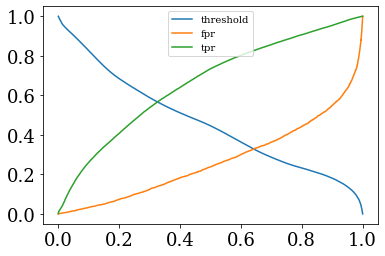

In [11]:
x = np.linspace(0,1,len(thresholds_200_10[2:]))
plt.plot(x, thresholds_200_10[2:], label='threshold')
plt.plot(x, fpr_200_10[2:], label='fpr')
plt.plot(x, tpr_200_10[2:], label='tpr')
plt.legend(loc='best')

In [12]:
selected = ((all_lambda == 200) & (all_ctau.astype(int) == 10))
tot = sum(all_real_weight[selected])
selected = ((all_lambda == 200) & (all_ctau.astype(int) == 10)) & (all_pred > 0.395)
sel = sum(all_real_weight[selected])
print(tot)

36403.0


(array([  700.,  1382.,  2373.,  3757.,  5910.,  8752., 12013., 15517.,
        19286., 22438., 18844., 16545., 15725., 15611., 16020., 17769.,
        20175., 25197., 33790., 39295., 38917., 38446., 38525., 39309.,
        40477., 42685., 44780., 42955., 36617., 31488., 31238., 32689.,
        36220., 42364., 50902., 64202., 80603., 97583., 58830., 91084.]),
 array([2.5410118e-04, 2.5247749e-02, 5.0241396e-02, 7.5235046e-02,
        1.0022869e-01, 1.2522234e-01, 1.5021598e-01, 1.7520963e-01,
        2.0020328e-01, 2.2519693e-01, 2.5019059e-01, 2.7518421e-01,
        3.0017787e-01, 3.2517153e-01, 3.5016516e-01, 3.7515882e-01,
        4.0015247e-01, 4.2514610e-01, 4.5013976e-01, 4.7513339e-01,
        5.0012708e-01, 5.2512068e-01, 5.5011433e-01, 5.7510799e-01,
        6.0010165e-01, 6.2509531e-01, 6.5008891e-01, 6.7508256e-01,
        7.0007622e-01, 7.2506988e-01, 7.5006354e-01, 7.7505720e-01,
        8.0005080e-01, 8.2504445e-01, 8.5003811e-01, 8.7503177e-01,
        9.0002543e-01, 9.2

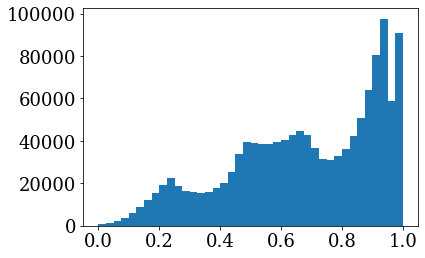

In [13]:
#selected = ((all_lambda == 200) & (all_ctau.astype(int) == 10))
selected = (all_label==1)
plt.hist(all_pred[selected], bins=40)

In [14]:
### Assuming choose WP FPR = 
wp = np.argmax(thresholds_sort < 0.32)
print("Working point index = {}".format(wp))
dnn_fpr = fpr_sort[wp]
dnn_tpr = tpr_sort[wp]
dnn_thres = thresholds_sort[wp]
print("Threshold = {} @ TPR = {}, FPR = {}".format(dnn_thres, dnn_tpr, dnn_fpr))


wp = np.argmax(tpr_sort > 0.7936)
print("Working point index = {}".format(wp))
dnn_fpr = fpr_sort[wp]
dnn_tpr = tpr_sort[wp]
dnn_thres = thresholds_sort[wp]
print("Threshold = {} @ TPR = {}, FPR = {}".format(dnn_thres, dnn_tpr, dnn_fpr))

wp = np.argmax(tpr_200_10 > 0.7936)
print("Working point index for (200TeV, 10cm) = {}".format(wp))
dnn_fpr = fpr_200_10[wp]
dnn_tpr = tpr_200_10[wp]
dnn_thres = thresholds_200_10[wp]
print("Threshold = {} @ TPR = {}, FPR = {}".format(dnn_thres, dnn_tpr, dnn_fpr))

Working point index = 2617135
Threshold = 0.3199986219406128 @ TPR = 0.8915502787346061, FPR = 0.3347292279877643
Working point index = 1931648
Threshold = 0.47164174914360046 @ TPR = 0.7936000644455168, FPR = 0.21504126176438376
Working point index for (200TeV, 10cm) = 1857918
Threshold = 0.37542054057121277 @ TPR = 0.7936159107765843, FPR = 0.2893924610105515


In [15]:
feature_names = ['pho1ecalPFClusterIso','pho1hcalPFClusterIso',
                 'pho1trkSumPtHollowConeDR03','pho1R9',
                 'pho1SigmaIetaIeta','pho1Smajor','pho1Sminor']

feature_df = pd.DataFrame(data=all_input,
                         columns=feature_names)

feature_df['isSignal'] = all_label
feature_df['weight'] = all_weight
feature_df['pred'] = all_pred
feature_df['process'] = all_process
feature_df['isoLoose'] = all_iso[:,0]
feature_df['isoTight'] = all_iso[:,2]
feature_df.head()

,pho1ecalPFClusterIso,pho1hcalPFClusterIso,pho1trkSumPtHollowConeDR03,pho1R9,pho1SigmaIetaIeta,pho1Smajor,pho1Sminor,isSignal,weight,pred,process,isoLoose,isoTight
0,0.002566,0.020402,0.0,0.929388,0.012698,0.561688,0.208127,1.0,1.068820,0.999942,0,1.0,1.0
1,0.001740,0.004010,0.0,0.947781,0.009014,0.376830,0.224104,1.0,0.975155,0.956837,0,1.0,1.0
2,0.005506,0.000000,0.0,0.940519,0.008636,0.346963,0.203206,1.0,0.798840,0.725564,0,1.0,1.0
3,0.007819,0.011772,0.0,0.937459,0.010451,0.386107,0.190069,1.0,1.054978,0.992845,0,1.0,1.0
4,0.000000,0.000000,0.0,0.949406,0.011106,0.408873,0.221490,1.0,1.152102,0.999368,0,1.0,1.0


(array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

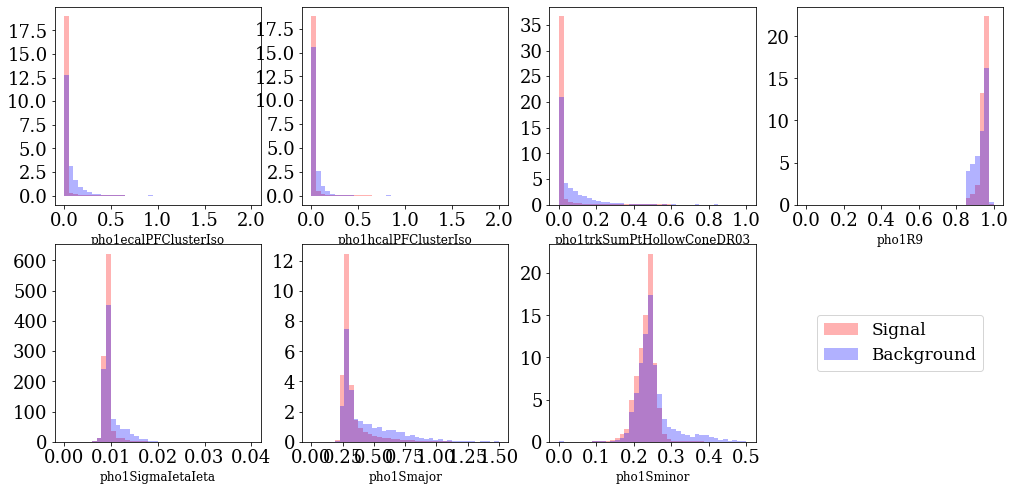

In [16]:
fig, ax = plt.subplots(2, 4, figsize=(17, 8))
xranges = {'pho1ecalPFClusterIso': (0,2),
           'pho1hcalPFClusterIso': (0, 2),
           'pho1trkSumPtHollowConeDR03': (0,1),
           'pho1R9': (0,1.),
           'pho1SigmaIetaIeta': (0, 0.04),
           'pho1Smajor': (0, 1.5),
           'pho1Sminor': (0, 0.5)
}

kwarg_plot = {'bins': 40,
              'density': True,
              'alpha': 0.3
              }

idx = 0

label_size = 8
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

for row in range(2):
    for col in range(4):
        if idx >= len(feature_names): continue
        to_plot = feature_names[idx]
        idx += 1
        ax[row, col].hist(feature_df[to_plot][feature_df['isSignal']==1], 
                          weights = feature_df['weight'][feature_df['isSignal']==1],
                          label='Signal', range = xranges[to_plot],
                          color='r',
                          **kwarg_plot)
        ax[row, col].hist(feature_df[to_plot][feature_df['isSignal']==0], 
                          weights = feature_df['weight'][feature_df['isSignal']==0],
                          label='Background', range = xranges[to_plot],
                          color='b',
                          **kwarg_plot)
        
        ax[row, col].set_xlabel(to_plot, fontsize=12)

# The last cell is for legend
ax[1,3].set_axis_off()
ax[1,3].hist([1,1], label='Signal', color='r', alpha=0.3)
ax[1,3].hist([1,1], label='Background', color='b', alpha=0.3)
ax[1,3].legend(loc='center', fontsize=17)
ax[1,3].hist([1,1], color='w')

#ax[1,3].get_yaxis().set_visible(False)


Text(1.2, 0.25, '2016 cut-based threshold')

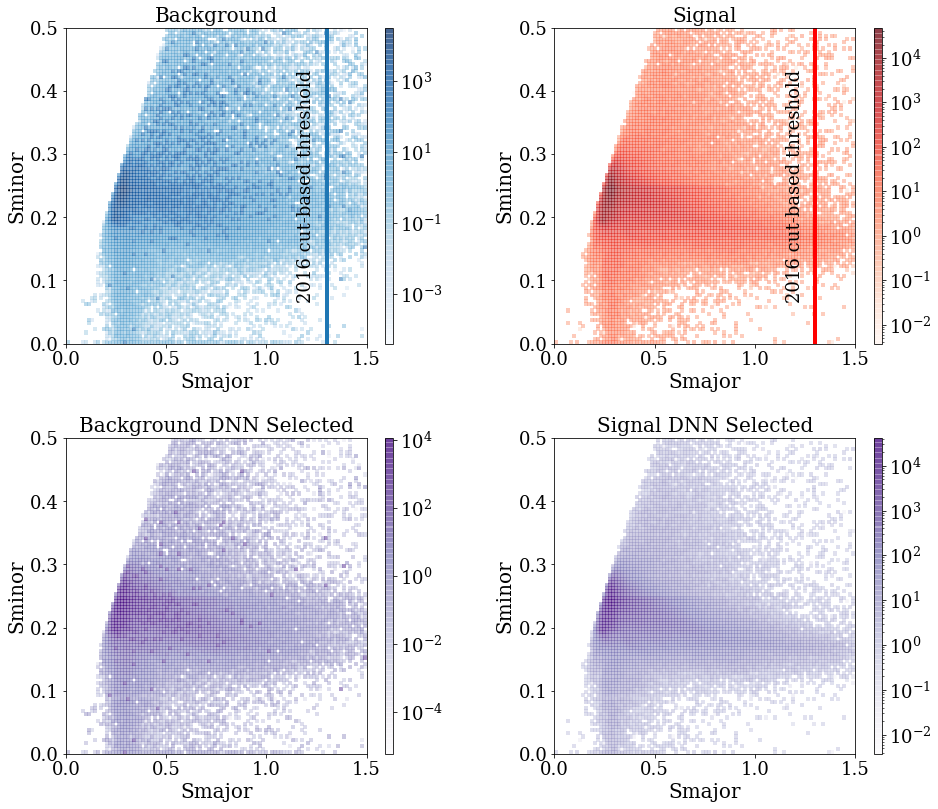

In [17]:
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


smajor_bkg = feature_df['pho1Smajor'][feature_df['isSignal']==0]
sminor_bkg = feature_df['pho1Sminor'][feature_df['isSignal']==0]
weight_bkg = feature_df['weight'][feature_df['isSignal']==0]
smajor_signal = feature_df['pho1Smajor'][feature_df['isSignal']==1]
sminor_signal = feature_df['pho1Sminor'][feature_df['isSignal']==1]
weight_signal = feature_df['weight'][feature_df['isSignal']==1]


smajor_bkg_selected = feature_df['pho1Smajor'][(feature_df['isSignal']==0) & (feature_df['pred']>dnn_thres)]
sminor_bkg_selected = feature_df['pho1Sminor'][(feature_df['isSignal']==0) & (feature_df['pred']>dnn_thres)]
weight_bkg_selected = feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['pred']>dnn_thres)]

smajor_signal_selected = feature_df['pho1Smajor'][(feature_df['isSignal']==1) & (feature_df['pred']>dnn_thres)]
sminor_signal_selected = feature_df['pho1Sminor'][(feature_df['isSignal']==1) & (feature_df['pred']>dnn_thres)]
weight_signal_selected = feature_df['weight'][(feature_df['isSignal']==1) & (feature_df['pred']>dnn_thres)]


from matplotlib.colors import LogNorm
fig, ax = plt.subplots(2, 2, figsize=(15,12))

chist = ax[0,0].hist2d(smajor_bkg, sminor_bkg, bins=100, 
           weights=weight_bkg, range=((0,1.5),(0.,0.5)), 
           norm=LogNorm(), cmap='Blues', alpha=0.5)
fig.colorbar(chist[3], ax=ax[0,0], aspect=40)
ax[0,0].plot([1.3, 1.3], [0, 0.5], lw=4)

chist = ax[1,0].hist2d(smajor_bkg_selected, sminor_bkg_selected, bins=100, 
           weights=weight_bkg_selected, range=((0,1.5),(0.,0.5)), 
           norm=LogNorm(), cmap='Purples', alpha=0.5)
fig.colorbar(chist[3], ax=ax[1,0], aspect=40)

chist = ax[0,1].hist2d(smajor_signal, sminor_signal, bins=100, 
           weights=weight_signal, range=((0,1.5),(0.,0.5)), 
           norm=LogNorm(), cmap='Reds', alpha=0.5)
fig.colorbar(chist[3], ax=ax[0, 1], aspect=40)
ax[0,1].plot([1.3, 1.3], [0, 0.5], lw=4, c='r')


chist = ax[1,1].hist2d(smajor_signal_selected, sminor_signal_selected, bins=100, 
           weights=weight_signal_selected, range=((0,1.5),(0.,0.5)), 
           norm=LogNorm(), cmap='Purples', alpha=0.5)
fig.colorbar(chist[3], ax=ax[1,1], aspect=40)

for i in (0, 1):
    for j in (0, 1):
        ax[i, j].set_xlabel('Smajor',fontsize=20)
        ax[i, j].set_ylabel('Sminor',fontsize=20)
ax[0,0].set_title('Background', fontsize=20)
ax[0,1].set_title('Signal', fontsize=20)
ax[1,0].set_title('Background DNN Selected', fontsize=20)
ax[1,1].set_title('Signal DNN Selected', fontsize=20)

plt.subplots_adjust(top=0.92, bottom=0.08, 
                    left=0.10, right=0.9, 
                    hspace=0.3, wspace=0.3)

ax[0,0].text(1.2, 0.25, '2016 cut-based threshold',
         rotation=90,
         size=18,
         horizontalalignment='center',
         verticalalignment='center',
         multialignment='center')

ax[0,1].text(1.2, 0.25, '2016 cut-based threshold',
         rotation=90,
         size=18,
         horizontalalignment='center',
         verticalalignment='center',
         multialignment='center')

Text(0.5, 0, 'DNN Prediction Score')

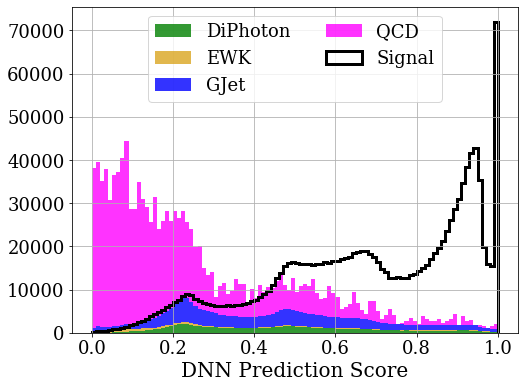

In [18]:
plt.figure(figsize=(8,6))

background = ([feature_df['pred'][(feature_df['isSignal']==0) & (feature_df['process']==1)],
                        feature_df['pred'][(feature_df['isSignal']==0) & (feature_df['process']==2)],
                        feature_df['pred'][(feature_df['isSignal']==0) & (feature_df['process']==3)],
                        feature_df['pred'][(feature_df['isSignal']==0) & (feature_df['process']==4)],
                       ])

background_weight = ([feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['process']==1)],
                        feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['process']==2)],
                        feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['process']==3)],
                        feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['process']==4)]
                       ])

#print(background.shape)
background_label = ['DiPhoton', 'EWK', 'GJet', 'QCD']
background_color = ['green', 'goldenrod', 'blue', 'magenta']
plt.hist(background, 
         bins=100, range=(0,1), stacked=True,
         weights=background_weight,
         label=background_label, color=background_color, alpha=0.8)
plt.hist(feature_df['pred'][feature_df['isSignal']==1], 
         bins=100, range=(0,1),
         weights=feature_df['weight'][feature_df['isSignal']==1],
         label='Signal', color='black', alpha=1, histtype='step',
         linewidth=3)
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=18)
plt.xlabel('DNN Prediction Score', fontsize=20)

(array([94624.859375  , 79923.7421875 , 91825.203125  , 86514.6796875 ,
        72829.21875   , 62669.8828125 , 59433.73828125, 53153.00390625,
        55078.2578125 , 40462.10546875, 33001.26953125, 22247.22460938,
        11892.15332031, 17149.99023438, 20782.47460938, 13250.98828125,
        13842.13671875, 15797.35742188, 18319.4765625 , 14921.49511719,
        13679.33984375, 17713.86328125, 11988.74511719, 13568.54394531,
         7764.75830078, 10951.51660156,  5968.015625  , 10002.41015625,
         4467.75878906,  6532.21777344,   427.84509277,  3513.49047852,
         2180.37524414,  3466.83740234,  1926.07788086,  4684.6796875 ,
         2475.07958984,  1582.24438477,   946.04644775,  1553.31640625]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0

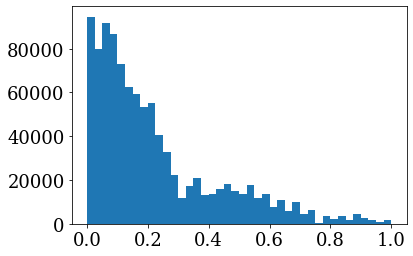

In [19]:
plt.hist(feature_df['pred'][(feature_df['isSignal']==0) & (feature_df['process']==4)],
        bins=40, range=(0, 1), 
        weights= feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['process']==4)])

Text(0.5, 0, 'Epoch')

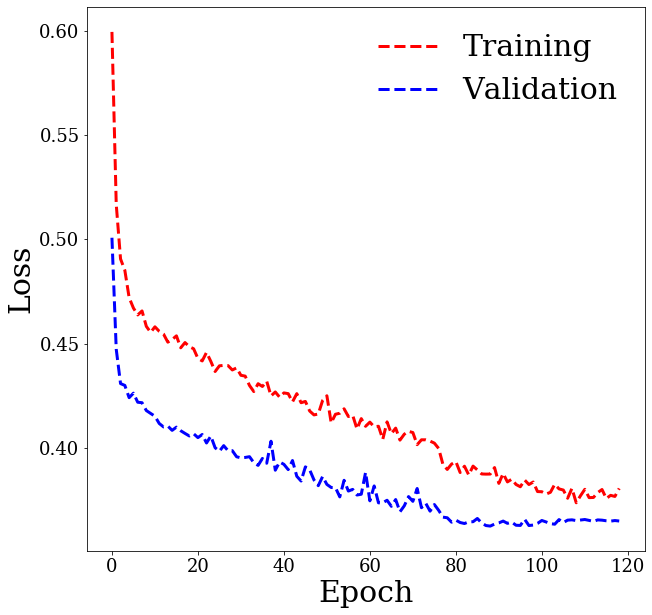

In [20]:
import matplotlib.pyplot as plt
import pickle
path = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/training_minimalCut_wPt/models/loss_hist.pkl'
losses = pickle.load(open(path, 'rb'))

plt.figure(figsize=(10,10))
plt.plot(losses['train'][:], lw=3, ls='--', color='r', label='Training')
plt.plot(losses['val'][:], lw=3, ls='--', color='b', label='Validation')
plt.legend(loc='best', fontsize=30, frameon=0)
plt.ylabel('Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=30)
